# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/LSTMx/"

df = pd.read_csv(data_path)

In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


Text(0, 0.5, 'Flucases')

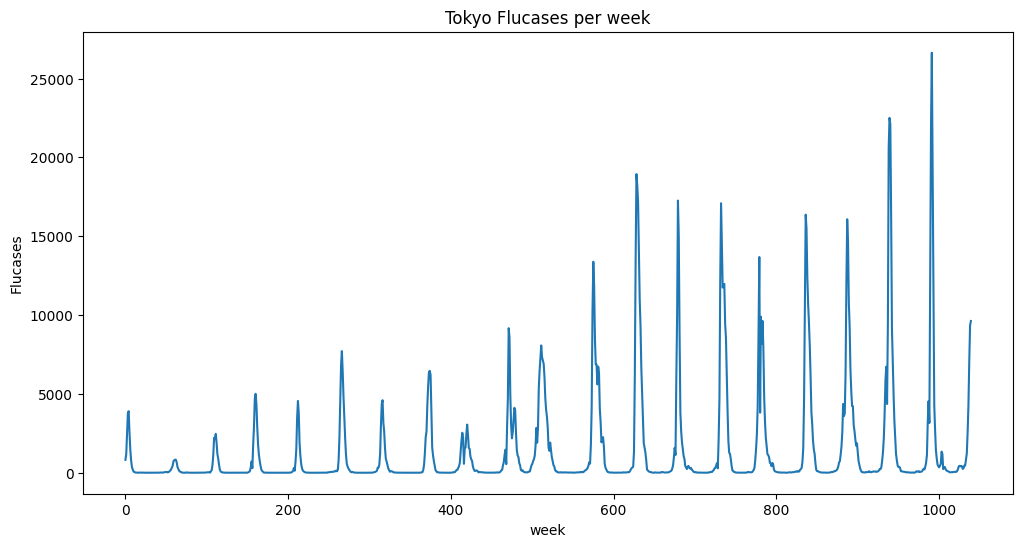

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))

plt.title("Tokyo Flucases per week")
plt.plot(np.arange(len(df_tokyo["Flucases"])), df_tokyo["Flucases"])

plt.xlabel("week")
plt.ylabel("Flucases")

In [4]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [5]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

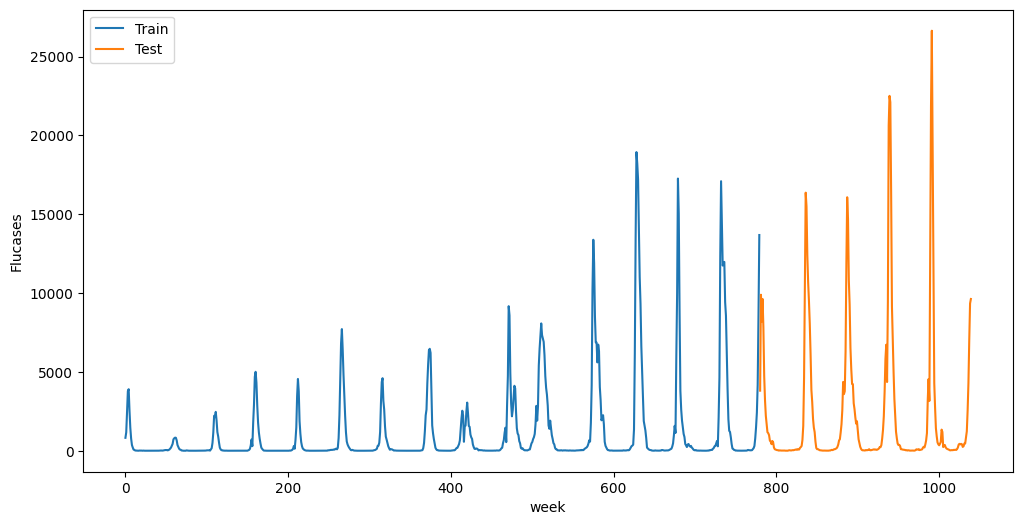

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(train_steps, df_tokyo["Flucases"][0:train_n],label="Train")
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

array([[<Axes: title={'center': 'Flucases'}>,
        <Axes: title={'center': 'Tempave'}>],
       [<Axes: title={'center': 'Rh'}>,
        <Axes: title={'center': 'Holiday'}>]], dtype=object)

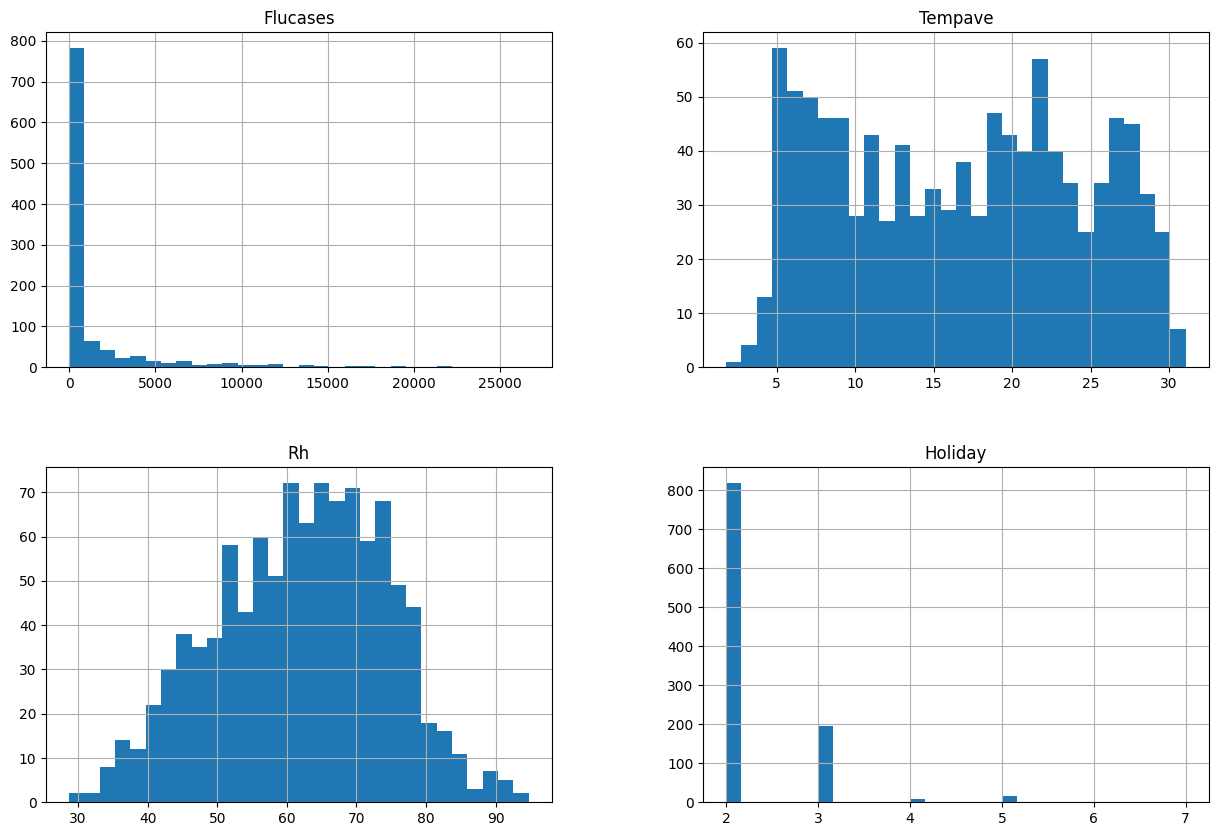

In [7]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]
all_data.hist(bins=30, figsize=(15, 10))

In [8]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [9]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [10]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [11]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [12]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [13]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/LSTMx/"

In [14]:
seq_length = 40

train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [15]:
train_Xs.shape, train_ys.shape

((740, 40, 4), (740, 1, 4))

In [16]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [17]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [18]:
train_Xs = np.concatenate([train_Xs[:,:,0:1], train_Xs[:,:,-2:-1]], axis = 2)
val_Xs = np.concatenate([val_Xs[:,:,0:1], val_Xs[:,:,-2:-1]], axis = 2)

In [19]:
train_ys = np.concatenate([train_ys[:,:,0:1], train_ys[:,:,-2:-1]], axis = 2)
val_ys = np.concatenate([val_ys[:,:,0:1], val_ys[:,:,-2:-1]], axis = 2)

In [20]:
train_Xs.shape, val_Xs.shape, train_ys.shape, val_ys.shape

((592, 40, 2), (148, 40, 2), (592, 1, 2), (148, 1, 2))

In [21]:
trn_xs_tensor = torch.Tensor(train_Xs)
trn_ys_tensor = torch.Tensor(train_ys)

val_xs_tensor = torch.Tensor(val_Xs)
val_ys_tensor = torch.Tensor(val_ys)

In [22]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([592, 40, 2]),
 torch.Size([592, 1, 2]),
 torch.Size([148, 40, 2]),
 torch.Size([148, 1, 2]))

In [23]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [24]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
2 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
3 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
4 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
5 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
6 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
7 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
8 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
9 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
10 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
11 torch.Size([42, 40, 2]) torch.Size([42, 1, 2])


In [25]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
1 torch.Size([50, 40, 2]) torch.Size([50, 1, 2])
2 torch.Size([48, 40, 2]) torch.Size([48, 1, 2])


In [26]:
#train_ts_df = train_df["Flucases"]
#train_ys_df = train_df[["Tempave", "Rh"]]
#train_xs_df = train_df["Holiday"]

#train_np = np.concatenate([train_ts_np.reshape(-1,1), train_ys_np, train_xs_np.reshape(-1,1)], axis = 1)

# LSTM model

In [27]:
class cLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_size=32, cond_size = 1, output_size=4, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cond_size = cond_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.cfc1 = nn.Linear(self.cond_size, int(self.hidden_size / 2))
        self.cfc2 = nn.Linear(int(self.hidden_size / 2), int(self.hidden_size / 4))
        
        self.fc1 = nn.Linear(int(self.hidden_size / 4) + self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x, cin):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        
        ch1 = self.relu(self.cfc1(cin))
        ch2 = self.cfc2(ch1)
        
        h_list = [outs, ch2]
        h1 = torch.cat(h_list, dim=1)
        h2 = self.relu(self.fc1(h1))
        y = self.relu(self.fc2(h2))
        
        return y

In [28]:
model = cLSTM(input_size = 2, hidden_size = 32, cond_size = 1, output_size = 1, num_layers = 1)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [29]:
model

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 32, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=16, bias=True)
  (cfc2): Linear(in_features=16, out_features=8, bias=True)
  (fc1): Linear(in_features=40, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

## Prediction

In [30]:
batch_0x = list(trn_loader)[0][0]
batch_0c = list(trn_loader)[0][1]

In [31]:
batch_0x.shape, batch_0c.shape

(torch.Size([50, 40, 2]), torch.Size([50, 1, 2]))

In [32]:
batch_0c = torch.reshape(batch_0c[:,:,-1], (batch_0c.shape[0], 1))

In [33]:
preds = model(batch_0x, batch_0c)

In [34]:
batch_0c.shape

torch.Size([50, 1])

In [35]:
preds = model(batch_0x, batch_0c)

In [36]:
preds.shape

torch.Size([50, 1])

## Train

In [37]:
model.cuda()

cLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 32, dropout=0.2)
  (cfc1): Linear(in_features=1, out_features=16, bias=True)
  (cfc2): Linear(in_features=16, out_features=8, bias=True)
  (fc1): Linear(in_features=40, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [38]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()
                input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
                true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))

            pred = model(inputs, input_c)
            pred = pred.reshape(true_y.shape)
            loss = criterion(pred, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [40]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
        true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))
        
        optimizer.zero_grad()
        
        pred = model(inputs, input_c)
        pred = pred.reshape(true_y.shape)
        loss = criterion(pred, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model" + ".pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.8740734631816546 Val loss:  0.7663545161485672
epoch:  1 Train loss:  0.7386506746212641 Val loss:  0.6614352365334829
epoch:  2 Train loss:  0.6290083105365435 Val loss:  0.5742238834500313
epoch:  3 Train loss:  0.5245867868264517 Val loss:  0.46816975623369217
epoch:  4 Train loss:  0.4048704132437706 Val loss:  0.3339301720261574
epoch:  5 Train loss:  0.26623460836708546 Val loss:  0.19845905900001526
epoch:  6 Train loss:  0.1797122855981191 Val loss:  0.10842381045222282
epoch:  7 Train loss:  0.12798886932432652 Val loss:  0.09056643272439639
epoch:  8 Train loss:  0.1162013638143738 Val loss:  0.08700492481390636
epoch:  9 Train loss:  0.11683556468536456 Val loss:  0.08592758203546207
epoch:  10 Train loss:  0.10901620890945196 Val loss:  0.08818938334782918
epoch:  11 Train loss:  0.10543866238246362 Val loss:  0.08375875279307365
epoch:  12 Train loss:  0.10995580147330959 Val loss:  0.083803395430247
epoch:  13 Train loss:  0.10335030034184456 Val 

epoch:  111 Train loss:  0.09534640796482563 Val loss:  0.10204157357414563
epoch:  112 Train loss:  0.0917866659971575 Val loss:  0.09868378813068072
epoch:  113 Train loss:  0.0953216365693758 Val loss:  0.10006452103455861
epoch:  114 Train loss:  0.09429047396406531 Val loss:  0.10020110507806142
epoch:  115 Train loss:  0.09168055808792512 Val loss:  0.10041045894225438
epoch:  116 Train loss:  0.09427281732981403 Val loss:  0.10179510215918224
epoch:  117 Train loss:  0.09765658938946824 Val loss:  0.09988832846283913
epoch:  118 Train loss:  0.0936487802149107 Val loss:  0.10115943104028702
epoch:  119 Train loss:  0.09175324253737926 Val loss:  0.09892217939098676
epoch:  120 Train loss:  0.09047006008525689 Val loss:  0.10170360406239827
epoch:  121 Train loss:  0.09268847038038075 Val loss:  0.1021047793328762
epoch:  122 Train loss:  0.09213440702296793 Val loss:  0.10127331937352817
epoch:  123 Train loss:  0.09476258093491197 Val loss:  0.10318379973371823
epoch:  124 Trai

epoch:  222 Train loss:  0.08786075313886006 Val loss:  0.1117557870845
epoch:  223 Train loss:  0.08531947806477547 Val loss:  0.10988541444142659
epoch:  224 Train loss:  0.08645817342524727 Val loss:  0.11167341346542041
epoch:  225 Train loss:  0.08875947554285328 Val loss:  0.1127072423696518
epoch:  226 Train loss:  0.08646686576927702 Val loss:  0.11288046464323997
epoch:  227 Train loss:  0.08839838982870181 Val loss:  0.11265892907977104
epoch:  228 Train loss:  0.08458063487584393 Val loss:  0.11276676754156749
epoch:  229 Train loss:  0.08604727607841293 Val loss:  0.11501392722129822
epoch:  230 Train loss:  0.08668039583911498 Val loss:  0.11295260861515999
epoch:  231 Train loss:  0.09125324517178039 Val loss:  0.11230338613192241
epoch:  232 Train loss:  0.08678402728401124 Val loss:  0.11510640010237694
epoch:  233 Train loss:  0.08371787099167705 Val loss:  0.11243099098404248
epoch:  234 Train loss:  0.0946264579736938 Val loss:  0.11621809005737305
epoch:  235 Train 

epoch:  332 Train loss:  0.07753728842362761 Val loss:  0.13156513000528017
epoch:  333 Train loss:  0.077726958397155 Val loss:  0.1308725861211618
epoch:  334 Train loss:  0.0756656884526213 Val loss:  0.1289523827532927
epoch:  335 Train loss:  0.08280621282756329 Val loss:  0.13428824146588644
epoch:  336 Train loss:  0.0800806915697952 Val loss:  0.12639028578996658
epoch:  337 Train loss:  0.08032560891782244 Val loss:  0.13402531171838442
epoch:  338 Train loss:  0.07464614409642915 Val loss:  0.12862499182422957
epoch:  339 Train loss:  0.07680096679056685 Val loss:  0.13280513882637024
epoch:  340 Train loss:  0.07496740606923898 Val loss:  0.13044366985559464
epoch:  341 Train loss:  0.07820424988555412 Val loss:  0.13468953718741736
epoch:  342 Train loss:  0.07766871185352404 Val loss:  0.13208153347174326
epoch:  343 Train loss:  0.07557729197045167 Val loss:  0.13456570853789648
epoch:  344 Train loss:  0.07558884751051664 Val loss:  0.13067432244618735
epoch:  345 Train 

epoch:  442 Train loss:  0.0766390214363734 Val loss:  0.14430183420578638
epoch:  443 Train loss:  0.0726838499152412 Val loss:  0.1494381700952848
epoch:  444 Train loss:  0.07196510078695913 Val loss:  0.14803744604190192
epoch:  445 Train loss:  0.06821509869769216 Val loss:  0.1536362941066424
epoch:  446 Train loss:  0.06767734761039416 Val loss:  0.14604668815930685
epoch:  447 Train loss:  0.06955498550087214 Val loss:  0.14984598010778427
epoch:  448 Train loss:  0.06997263617813587 Val loss:  0.1443685938914617
epoch:  449 Train loss:  0.07151843366834025 Val loss:  0.15348617235819498
epoch:  450 Train loss:  0.07651872839778662 Val loss:  0.1441530262430509
epoch:  451 Train loss:  0.06938738833802442 Val loss:  0.1604010115067164
epoch:  452 Train loss:  0.07280279649421573 Val loss:  0.14976214369138083
epoch:  453 Train loss:  0.06971041687453787 Val loss:  0.14550707737604776
epoch:  454 Train loss:  0.06597182309875886 Val loss:  0.14749626318613687
epoch:  455 Train l

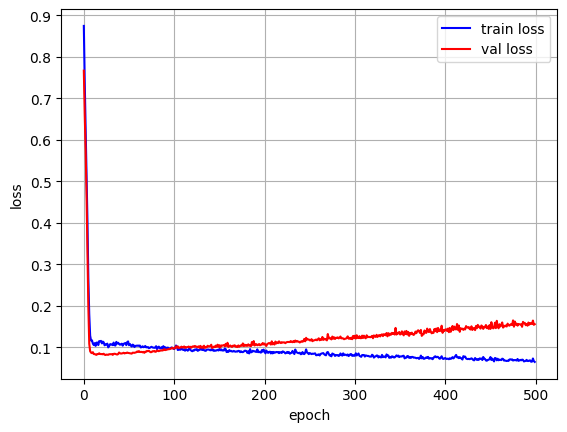

In [44]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [45]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(24, 0.08143727978070577)

In [32]:
save_model_path = exp_dir + "best_model" + ".pt"

model = torch.load(save_model_path)

### Scatter plot

In [33]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

torch.Size([1, 1]) torch.Size([1, 1])
225
torch.Size([1, 1]) torch.Size([1, 1])
226
torch.Size([1, 1]) torch.Size([1, 1])
227
torch.Size([1, 1]) torch.Size([1, 1])
228
torch.Size([1, 1]) torch.Size([1, 1])
229
torch.Size([1, 1]) torch.Size([1, 1])
230
torch.Size([1, 1]) torch.Size([1, 1])
231
torch.Size([1, 1]) torch.Size([1, 1])
232
torch.Size([1, 1]) torch.Size([1, 1])
233
torch.Size([1, 1]) torch.Size([1, 1])
234
torch.Size([1, 1]) torch.Size([1, 1])
235
torch.Size([1, 1]) torch.Size([1, 1])
236
torch.Size([1, 1]) torch.Size([1, 1])
237
torch.Size([1, 1]) torch.Size([1, 1])
238
torch.Size([1, 1]) torch.Size([1, 1])
239
torch.Size([1, 1]) torch.Size([1, 1])
240
torch.Size([1, 1]) torch.Size([1, 1])
241
torch.Size([1, 1]) torch.Size([1, 1])
242
torch.Size([1, 1]) torch.Size([1, 1])
243
torch.Size([1, 1]) torch.Size([1, 1])
244
torch.Size([1, 1]) torch.Size([1, 1])
245
torch.Size([1, 1]) torch.Size([1, 1])
246
torch.Size([1, 1]) torch.Size([1, 1])
247
torch.Size([1, 1]) torch.Size([1, 

torch.Size([1, 1]) torch.Size([1, 1])
555
torch.Size([1, 1]) torch.Size([1, 1])
556
torch.Size([1, 1]) torch.Size([1, 1])
557
torch.Size([1, 1]) torch.Size([1, 1])
558
torch.Size([1, 1]) torch.Size([1, 1])
559
torch.Size([1, 1]) torch.Size([1, 1])
560
torch.Size([1, 1]) torch.Size([1, 1])
561
torch.Size([1, 1]) torch.Size([1, 1])
562
torch.Size([1, 1]) torch.Size([1, 1])
563
torch.Size([1, 1]) torch.Size([1, 1])
564
torch.Size([1, 1]) torch.Size([1, 1])
565
torch.Size([1, 1]) torch.Size([1, 1])
566
torch.Size([1, 1]) torch.Size([1, 1])
567
torch.Size([1, 1]) torch.Size([1, 1])
568
torch.Size([1, 1]) torch.Size([1, 1])
569
torch.Size([1, 1]) torch.Size([1, 1])
570
torch.Size([1, 1]) torch.Size([1, 1])
571
torch.Size([1, 1]) torch.Size([1, 1])
572
torch.Size([1, 1]) torch.Size([1, 1])
573
torch.Size([1, 1]) torch.Size([1, 1])
574
torch.Size([1, 1]) torch.Size([1, 1])
575
torch.Size([1, 1]) torch.Size([1, 1])
576
torch.Size([1, 1]) torch.Size([1, 1])
577
torch.Size([1, 1]) torch.Size([1, 

In [34]:
np.array(trues_list).shape, np.array(preds_list).shape

((592, 1, 1), (592, 1, 1))

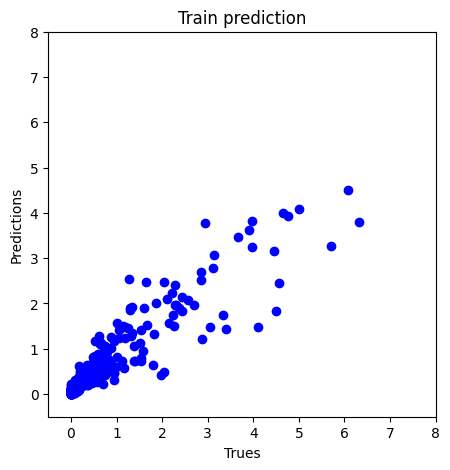

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [36]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

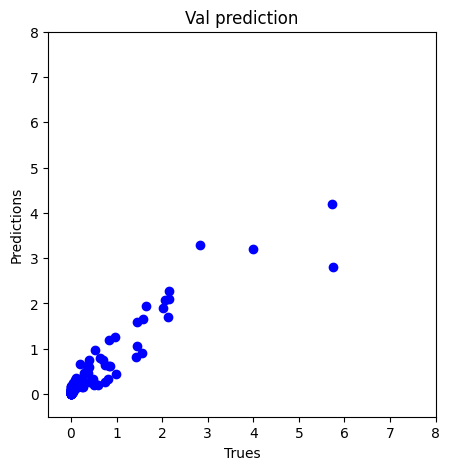

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [38]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [39]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [40]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [41]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [42]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [43]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [44]:
test_all_np.shape

(260, 4)

In [45]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [46]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [47]:
#何週前のデータから予測するか

seq_length = 40

test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [48]:
test_Xs = np.concatenate([test_Xs[:,:,0:1], test_Xs[:,:,-2:-1]], axis = 2)
test_ys = np.concatenate([test_ys[:,:,0:1], test_ys[:,:,-2:-1]], axis = 2)

In [49]:
tst_xs_tensor = torch.Tensor(test_Xs)
tst_ys_tensor = torch.Tensor(test_ys)

In [50]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [51]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        
        preds = model(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


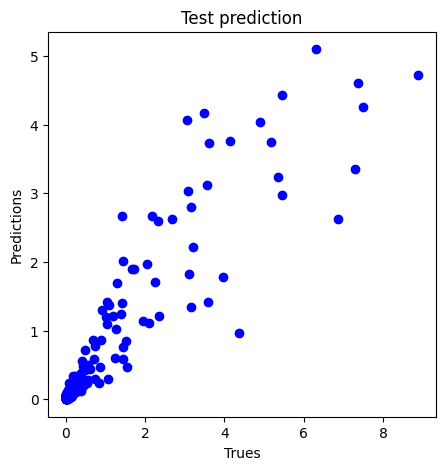

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [53]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [54]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

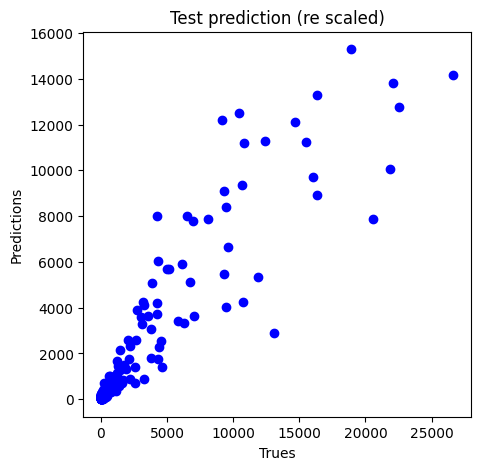

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [56]:
tst_preds.shape

(220, 1)

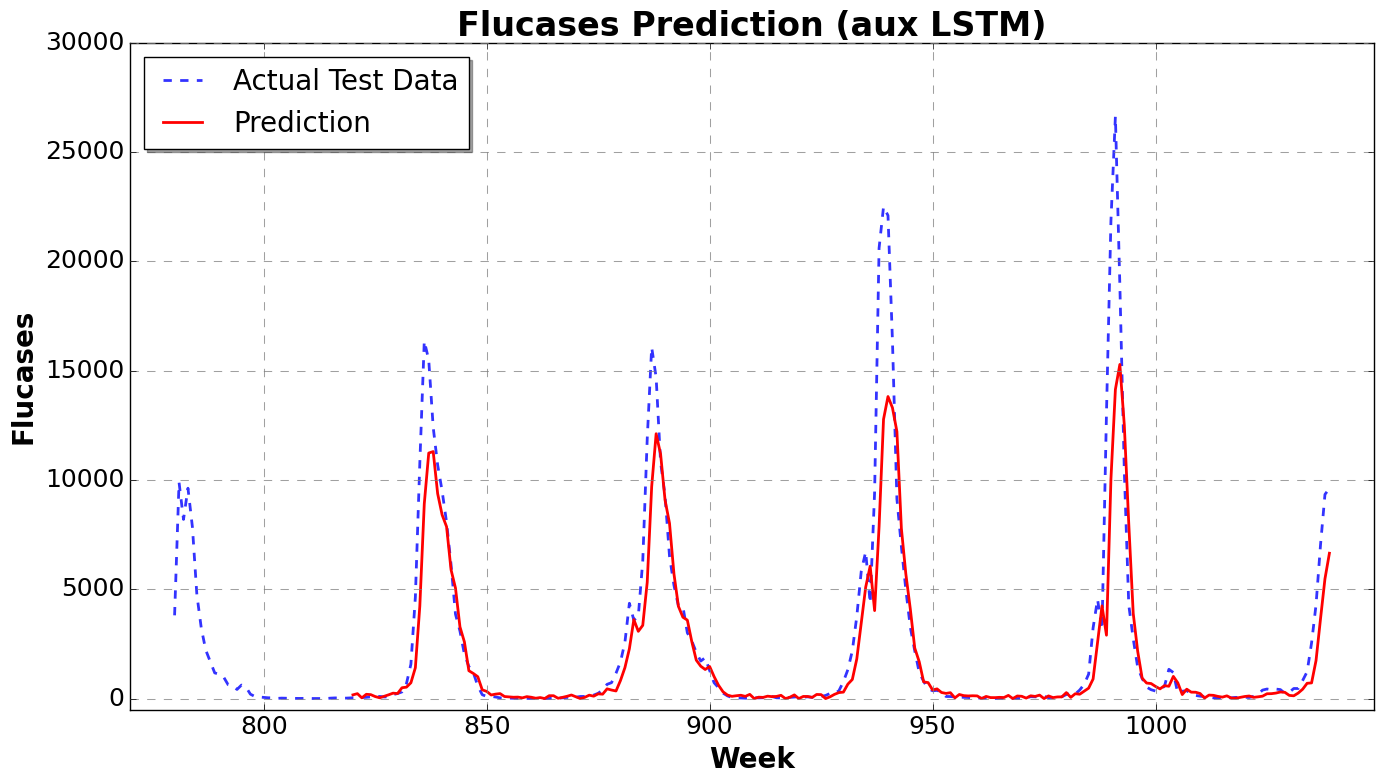

In [57]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (aux LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
plt.savefig("Flucases Prediction (aux LSTM).jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [72]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [73]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 5133720.106336422.
RMSE : 2265.771415288052.
MAE : 887.4577808789231.
R2 : 0.7779469426581573.
pearson : 0.9193997262254017 2.65497791271377e-90


### 2. step by step prediction

In [71]:
len(tst_dataset)

220

In [72]:
init_dat = tst_dataset[0]

In [73]:
init_inputs, init_trues = init_dat

In [74]:
init_inputs.shape, init_trues.shape

(torch.Size([40, 2]), torch.Size([1, 2]))

In [75]:
init_inputs, init_trues = init_inputs.cuda(), init_trues.cuda()
        
init_inputs = torch.reshape(init_inputs, (1, seq_length, init_inputs.shape[-1]))
init_trues = torch.reshape(init_trues, (1, 1, init_trues.shape[-1]))
input_c = torch.reshape(init_trues[:,:,-1], (init_trues.shape[0], 1))
        
preds = model(init_inputs, input_c)

In [76]:
preds.shape, input_c.shape

(torch.Size([1, 1]), torch.Size([1, 1]))

In [77]:
preds_cat = torch.cat([preds, input_c], dim=1)

In [78]:
preds_cat = torch.reshape(preds_cat, (1, 1, preds_cat.shape[-1]))
preds_cat.shape

torch.Size([1, 1, 2])

In [79]:
init_inputs.shape

torch.Size([1, 40, 2])

In [80]:
stack_inputs = torch.cat([init_inputs, preds_cat], dim=1)

In [81]:
stack_inputs.shape

torch.Size([1, 41, 2])

In [82]:
test_np.shape

(260, 4)

In [83]:
from torch.utils.data import TensorDataset, DataLoader

#test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

tst_input_tensor = torch.from_numpy(test_np[:,-1].reshape(-1,1).astype(np.float32)).clone()
tst_input_dataset = TensorDataset(tst_input_tensor)

In [84]:
stack_inputs.shape, len(tst_input_dataset)

(torch.Size([1, 41, 2]), 260)

In [85]:
model.eval()

with torch.no_grad():
    for id, tst_input in enumerate(list(tst_input_dataset)[len(stack_inputs[0]):]):
        print(id)

        input_c = torch.reshape(tst_input[0], (tst_input[0].shape[0], 1)).cuda()

        preds = model(stack_inputs[:,-seq_length:,:].cuda(), input_c.cuda())
        preds_cat = torch.cat([preds, input_c], dim=1)

        preds_cat = torch.reshape(preds_cat, (1, 1, preds_cat.shape[-1]))
        stack_inputs = torch.cat([stack_inputs, preds_cat], dim=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


In [86]:
stack_inputs.shape, len(tst_input_dataset)

(torch.Size([1, 260, 2]), 260)

In [87]:
ae_scaled_preds = stack_inputs[0][:,0].to('cpu').detach().numpy().copy()

In [88]:
ae_scaled_preds.shape

(260,)

In [89]:
test_scaled_ts.shape

(260,)

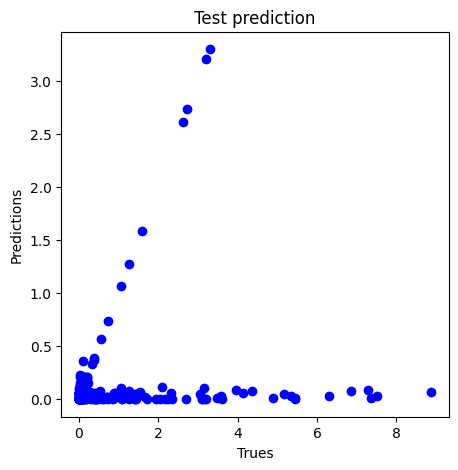

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_scaled_ts, ae_scaled_preds, c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [91]:
#rescaled_tst_trues = (np.array(test_scaled_ts) - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min
rescaled_tst_preds = (np.array(ae_scaled_preds) - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

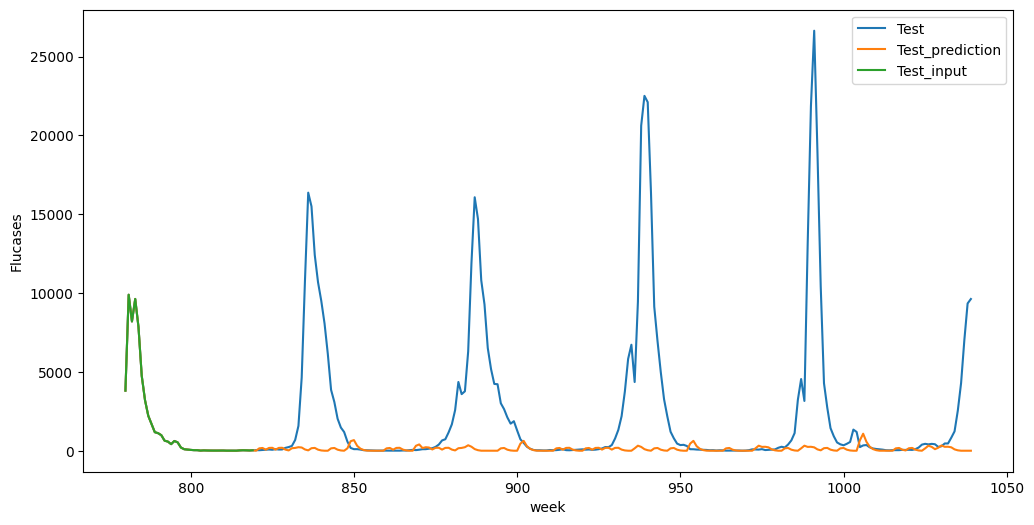

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps, rescaled_tst_preds,label="Test_prediction")
plt.plot(test_steps[0:seq_length], rescaled_tst_preds[0:seq_length],label="Test_input")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

# Bidirectional LSTM model

In [93]:
class bdcLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_size=32, cond_size = 1, output_size=4, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cond_size = cond_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2, bidirectional=True)
        
        self.cfc = nn.Linear(self.cond_size, int(self.hidden_size / 4))
        
        self.fc1 = nn.Linear(int(self.hidden_size / 4) + self.hidden_size * 2, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x, cin):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden * 2)
        outs = last_outs[:, -1, :] #(batch_size, hidden * 2)
        
        ch = self.relu(self.cfc(cin))
        
        h_list = [outs, ch]
        h1 = torch.cat(h_list, dim=1)
        h2 = self.relu(self.fc1(h1))
        h3 = self.fc2(h2)
        
        y_list = [self.relu(h3[:,0:1]), h3[:,1:3]]
        ys = torch.cat(y_list, dim=1)

        return ys

In [94]:
class bdcLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_size=32, cond_size = 1, output_size=4, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.cond_size = cond_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2, bidirectional=True)
        
        self.cfc1 = nn.Linear(self.cond_size, int(self.hidden_size / 2))
        self.cfc2 = nn.Linear(int(self.hidden_size / 2), int(self.hidden_size / 4))
        
        self.fc1 = nn.Linear(int(self.hidden_size / 4) + self.hidden_size * 2, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x, cin):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        
        ch1 = self.relu(self.cfc1(cin))
        ch2 = self.cfc2(ch1)
        
        h_list = [outs, ch2]
        h1 = torch.cat(h_list, dim=1)
        h2 = self.relu(self.fc1(h1))
        y = self.relu(self.fc2(h2))
        
        return y

In [95]:
bimodel = bdcLSTM(input_size = 2, hidden_size = 32, cond_size = 1, output_size = 1, num_layers = 1)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [96]:
batch_0x = list(trn_loader)[0][0]
batch_0c = list(trn_loader)[0][1]

In [97]:
batch_0c = torch.reshape(batch_0c[:,:,-1], (batch_0c.shape[0], 1))

In [98]:
preds = bimodel(batch_0x, batch_0c)

In [99]:
preds.shape

torch.Size([50, 1])

## Train

In [100]:
bimodel.cuda()

bdcLSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(2, 32, dropout=0.2, bidirectional=True)
  (cfc1): Linear(in_features=1, out_features=16, bias=True)
  (cfc2): Linear(in_features=16, out_features=8, bias=True)
  (fc1): Linear(in_features=72, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [101]:
criterion = nn.MSELoss(reduction='mean').cuda()
optimizer = optim.Adam(bimodel.parameters(), lr=1e-3)

In [102]:
def val_model(epoch):
    
    bimodel.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()
                input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
                true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))

            pred = bimodel(inputs, input_c)
            pred = pred.reshape(true_y.shape)
            loss = criterion(pred, true_y)
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [103]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    bimodel.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        input_c = torch.reshape(trues[:,:,-1], (trues.shape[0], 1))
        true_y = torch.reshape(trues[:,:,0:1], (trues.shape[0], 1))
        
        optimizer.zero_grad()
        
        pred = bimodel(inputs, input_c)
        pred = pred.reshape(true_y.shape)
        loss = criterion(pred, true_y)
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_bimodel" + ".pt"
        torch.save(bimodel, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.8331866537531217 Val loss:  0.7173837820688883
epoch:  1 Train loss:  0.6770284523566564 Val loss:  0.6076612671216329
epoch:  2 Train loss:  0.5480419161419073 Val loss:  0.49573444078365964
epoch:  3 Train loss:  0.41249225102365017 Val loss:  0.3432317065695922
epoch:  4 Train loss:  0.25921153898040455 Val loss:  0.18010169391830763
epoch:  5 Train loss:  0.15541760452712575 Val loss:  0.10939707731207211
epoch:  6 Train loss:  0.14343267989655337 Val loss:  0.09454411392410596
epoch:  7 Train loss:  0.12896924186497927 Val loss:  0.08843205248316129
epoch:  8 Train loss:  0.11585091395924489 Val loss:  0.08640797436237335
epoch:  9 Train loss:  0.11735414527356625 Val loss:  0.08424367755651474
epoch:  10 Train loss:  0.11864706237489979 Val loss:  0.08450712884465854
epoch:  11 Train loss:  0.1078263985303541 Val loss:  0.08648573358853658
epoch:  12 Train loss:  0.11142388762285312 Val loss:  0.08337467287977536
epoch:  13 Train loss:  0.1101239463314414

epoch:  113 Train loss:  0.10478874295949936 Val loss:  0.0873854657014211
epoch:  114 Train loss:  0.11254823735604684 Val loss:  0.08995436877012253
epoch:  115 Train loss:  0.10428324807435274 Val loss:  0.0896384206910928
epoch:  116 Train loss:  0.10614808020181954 Val loss:  0.08825740714867909
epoch:  117 Train loss:  0.1052768702308337 Val loss:  0.08841978137691815
epoch:  118 Train loss:  0.10625676531344652 Val loss:  0.08821321154634158
epoch:  119 Train loss:  0.10537916328758001 Val loss:  0.08934111520648003
epoch:  120 Train loss:  0.10287236453344424 Val loss:  0.09010058765610059
epoch:  121 Train loss:  0.10503114589179556 Val loss:  0.08978011707464854
epoch:  122 Train loss:  0.1064446068679293 Val loss:  0.09050103401144345
epoch:  123 Train loss:  0.10309559758752584 Val loss:  0.0891845573981603
epoch:  124 Train loss:  0.10190278369312485 Val loss:  0.08830787365635236
epoch:  125 Train loss:  0.09902238147333264 Val loss:  0.0906614400446415
epoch:  126 Train 

epoch:  223 Train loss:  0.09407851596673329 Val loss:  0.09834748258193333
epoch:  224 Train loss:  0.0896934893486711 Val loss:  0.09868878871202469
epoch:  225 Train loss:  0.09173190888638298 Val loss:  0.09680568302671115
epoch:  226 Train loss:  0.09040790516883135 Val loss:  0.09721802299221356
epoch:  227 Train loss:  0.08876303303986788 Val loss:  0.09693309540549915
epoch:  228 Train loss:  0.0903784519371887 Val loss:  0.09710818653305371
epoch:  229 Train loss:  0.09037100345206757 Val loss:  0.09636390209197998
epoch:  230 Train loss:  0.08889409930755694 Val loss:  0.0964457131922245
epoch:  231 Train loss:  0.09217645786702633 Val loss:  0.103056105474631
epoch:  232 Train loss:  0.08778620169808467 Val loss:  0.09879887600739796
epoch:  233 Train loss:  0.09208055376075208 Val loss:  0.09942318747440974
epoch:  234 Train loss:  0.08805295685306191 Val loss:  0.09802084788680077
epoch:  235 Train loss:  0.08760803611949086 Val loss:  0.10042023782928784
epoch:  236 Train

epoch:  332 Train loss:  0.08710900632043679 Val loss:  0.10555216545859973
epoch:  333 Train loss:  0.08652284182608128 Val loss:  0.10304708282152812
epoch:  334 Train loss:  0.08352879636610548 Val loss:  0.1030496967335542
epoch:  335 Train loss:  0.08486782154068351 Val loss:  0.10793280353148778
epoch:  336 Train loss:  0.0809284826585402 Val loss:  0.10431502759456635
epoch:  337 Train loss:  0.0806278942618519 Val loss:  0.10432518646121025
epoch:  338 Train loss:  0.08244603224253903 Val loss:  0.10445598388711612
epoch:  339 Train loss:  0.08270576658348243 Val loss:  0.10658675308028857
epoch:  340 Train loss:  0.08212755496303241 Val loss:  0.10526914770404498
epoch:  341 Train loss:  0.08292171840245526 Val loss:  0.1099082628885905
epoch:  342 Train loss:  0.08269200815508763 Val loss:  0.10472589234511058
epoch:  343 Train loss:  0.08198099109965067 Val loss:  0.10765240341424942
epoch:  344 Train loss:  0.08185203357910116 Val loss:  0.10478513439496358
epoch:  345 Trai

epoch:  443 Train loss:  0.074622286328425 Val loss:  0.11835036426782608
epoch:  444 Train loss:  0.07342077248419325 Val loss:  0.12071603909134865
epoch:  445 Train loss:  0.07424314700377484 Val loss:  0.11806287492314975
epoch:  446 Train loss:  0.07737829660375913 Val loss:  0.12489156673351924
epoch:  447 Train loss:  0.07882454867164294 Val loss:  0.1207277054588
epoch:  448 Train loss:  0.08063800757129987 Val loss:  0.12286383907000224
epoch:  449 Train loss:  0.07786605724443992 Val loss:  0.11950296411911647
epoch:  450 Train loss:  0.0756001037855943 Val loss:  0.11848522474368413
epoch:  451 Train loss:  0.07280776680757602 Val loss:  0.12099943806727727
epoch:  452 Train loss:  0.07703906763345003 Val loss:  0.12268686542908351
epoch:  453 Train loss:  0.07448408589698374 Val loss:  0.12184256066878636
epoch:  454 Train loss:  0.07594923457751672 Val loss:  0.11976523573199908
epoch:  455 Train loss:  0.07945959797749917 Val loss:  0.11897871767481168
epoch:  456 Train l

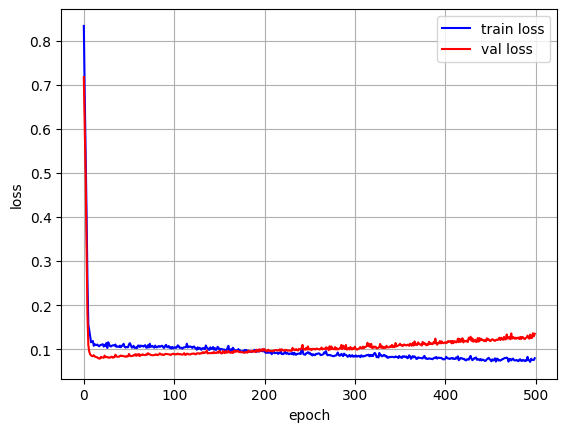

In [104]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [105]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(17, 0.07882833480834961)

In [106]:
save_model_path = exp_dir + "best_bimodel" + ".pt"

bimodel = torch.load(save_model_path)

### Scatter plot

In [107]:
preds_list = []
trues_list = []

bimodel.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = bimodel(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

332
torch.Size([1, 1]) torch.Size([1, 1])
333
torch.Size([1, 1]) torch.Size([1, 1])
334
torch.Size([1, 1]) torch.Size([1, 1])
335
torch.Size([1, 1]) torch.Size([1, 1])
336
torch.Size([1, 1]) torch.Size([1, 1])
337
torch.Size([1, 1]) torch.Size([1, 1])
338
torch.Size([1, 1]) torch.Size([1, 1])
339
torch.Size([1, 1]) torch.Size([1, 1])
340
torch.Size([1, 1]) torch.Size([1, 1])
341
torch.Size([1, 1]) torch.Size([1, 1])
342
torch.Size([1, 1]) torch.Size([1, 1])
343
torch.Size([1, 1]) torch.Size([1, 1])
344
torch.Size([1, 1]) torch.Size([1, 1])
345
torch.Size([1, 1]) torch.Size([1, 1])
346
torch.Size([1, 1]) torch.Size([1, 1])
347
torch.Size([1, 1]) torch.Size([1, 1])
348
torch.Size([1, 1]) torch.Size([1, 1])
349
torch.Size([1, 1]) torch.Size([1, 1])
350
torch.Size([1, 1]) torch.Size([1, 1])
351
torch.Size([1, 1]) torch.Size([1, 1])
352
torch.Size([1, 1]) torch.Size([1, 1])
353
torch.Size([1, 1]) torch.Size([1, 1])
354
torch.Size([1, 1]) torch.Size([1, 1])
355
torch.Size([1, 1]) torch.Size(

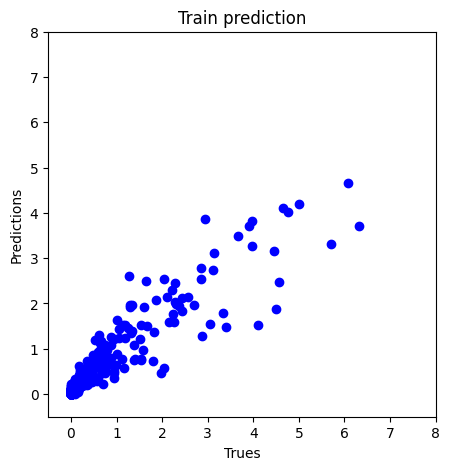

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [109]:
preds_list = []
trues_list = []

bimodel.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        print(input_c.shape, input_c.shape)
        
        preds = bimodel(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

torch.Size([1, 1]) torch.Size([1, 1])
0
torch.Size([1, 1]) torch.Size([1, 1])
1
torch.Size([1, 1]) torch.Size([1, 1])
2
torch.Size([1, 1]) torch.Size([1, 1])
3
torch.Size([1, 1]) torch.Size([1, 1])
4
torch.Size([1, 1]) torch.Size([1, 1])
5
torch.Size([1, 1]) torch.Size([1, 1])
6
torch.Size([1, 1]) torch.Size([1, 1])
7
torch.Size([1, 1]) torch.Size([1, 1])
8
torch.Size([1, 1]) torch.Size([1, 1])
9
torch.Size([1, 1]) torch.Size([1, 1])
10
torch.Size([1, 1]) torch.Size([1, 1])
11
torch.Size([1, 1]) torch.Size([1, 1])
12
torch.Size([1, 1]) torch.Size([1, 1])
13
torch.Size([1, 1]) torch.Size([1, 1])
14
torch.Size([1, 1]) torch.Size([1, 1])
15
torch.Size([1, 1]) torch.Size([1, 1])
16
torch.Size([1, 1]) torch.Size([1, 1])
17
torch.Size([1, 1]) torch.Size([1, 1])
18
torch.Size([1, 1]) torch.Size([1, 1])
19
torch.Size([1, 1]) torch.Size([1, 1])
20
torch.Size([1, 1]) torch.Size([1, 1])
21
torch.Size([1, 1]) torch.Size([1, 1])
22
torch.Size([1, 1]) torch.Size([1, 1])
23
torch.Size([1, 1]) torch.S

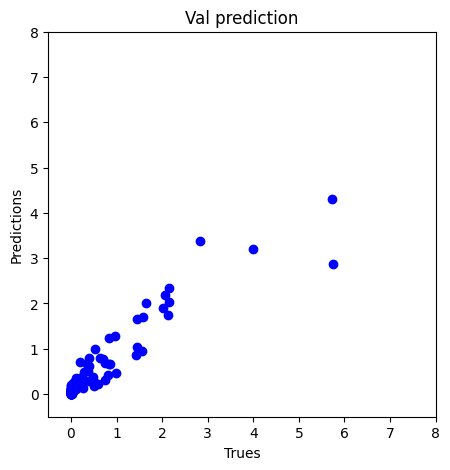

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test Prediction

In [111]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [112]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [113]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [114]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [115]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

### 1. Prediction based on results from 40 days ago

In [116]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [117]:
#何週前のデータから予測するか

seq_length = 40

test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [118]:
test_Xs = np.concatenate([test_Xs[:,:,0:1], test_Xs[:,:,-2:-1]], axis = 2)
test_ys = np.concatenate([test_ys[:,:,0:1], test_ys[:,:,-2:-1]], axis = 2)

In [119]:
tst_xs_tensor = torch.Tensor(test_Xs)
tst_ys_tensor = torch.Tensor(test_ys)

In [120]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [121]:
preds_list = []
trues_list = []

bimodel.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        input_c = torch.reshape(trues[:,-1], (trues.shape[0], 1))
        true_y = trues[:,0:1]
        
        preds = bimodel(inputs, input_c)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


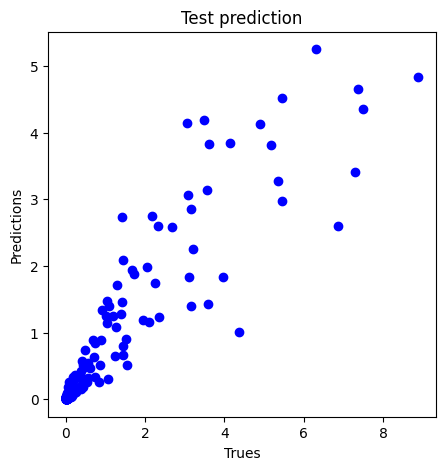

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [123]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [124]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

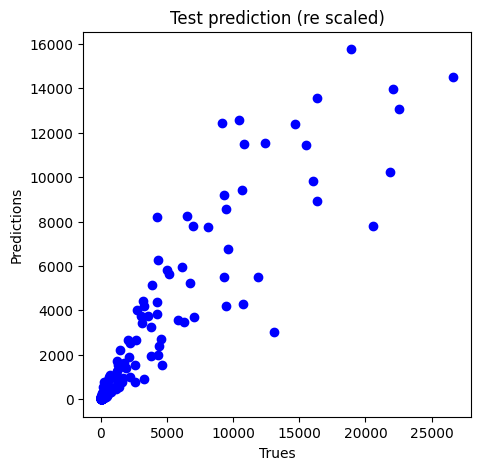

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

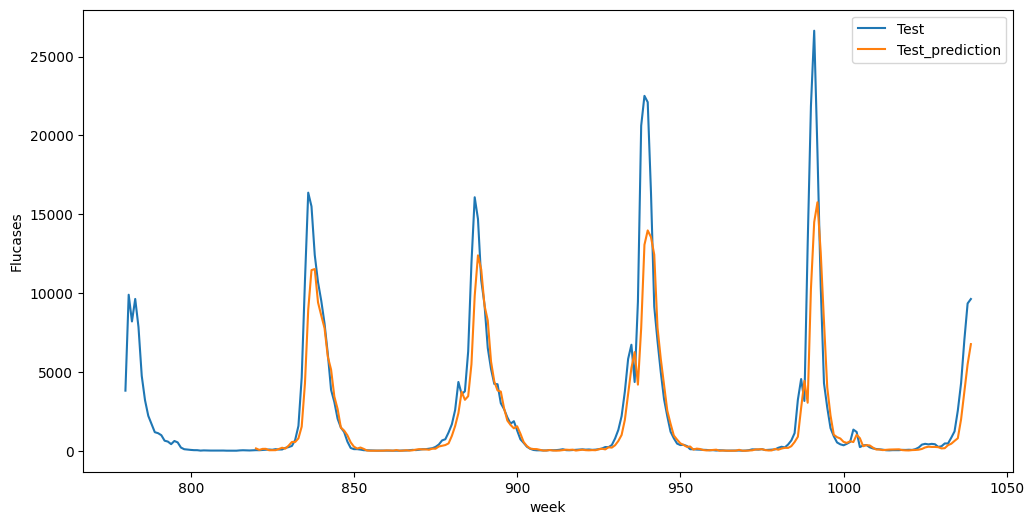

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps[seq_length:], tst_preds,label="Test_prediction")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()

In [127]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [128]:
test_np[seq_length:,0].shape, tst_preds[:,0].shape

((220,), (220,))

In [129]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 4957190.58858213.
RMSE : 2226.474924310204.
MAE : 860.9069000374187.
R2 : 0.7855825204295359.
pearson : 0.9194181036934881 2.5924530056325764e-90


### 2. step by step prediction

In [130]:
init_dat = tst_dataset[0]

In [131]:
init_inputs, init_trues = init_dat

In [132]:
init_inputs, init_trues = init_inputs.cuda(), init_trues.cuda()
        
init_inputs = torch.reshape(init_inputs, (1, seq_length, init_inputs.shape[-1]))
init_trues = torch.reshape(init_trues, (1, 1, init_trues.shape[-1]))
input_c = torch.reshape(init_trues[:,:,-1], (init_trues.shape[0], 1))
        
preds = model(init_inputs, input_c)

In [133]:
preds_cat = torch.cat([preds, input_c], dim=1)

In [134]:
preds_cat = torch.reshape(preds_cat, (1, 1, preds_cat.shape[-1]))
preds_cat.shape

torch.Size([1, 1, 2])

In [135]:
stack_inputs = torch.cat([init_inputs, preds_cat], dim=1)

In [136]:
from torch.utils.data import TensorDataset, DataLoader

#test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

tst_input_tensor = torch.from_numpy(test_np[:,-1].reshape(-1,1).astype(np.float32)).clone()
tst_input_dataset = TensorDataset(tst_input_tensor)

In [137]:
bimodel.eval()

with torch.no_grad():
    for id, tst_input in enumerate(list(tst_input_dataset)[len(stack_inputs[0]):]):
        print(id)

        input_c = torch.reshape(tst_input[0], (tst_input[0].shape[0], 1)).cuda()

        preds = bimodel(stack_inputs[:,-seq_length:,:].cuda(), input_c.cuda())
        preds_cat = torch.cat([preds, input_c], dim=1)

        preds_cat = torch.reshape(preds_cat, (1, 1, preds_cat.shape[-1]))
        stack_inputs = torch.cat([stack_inputs, preds_cat], dim=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


In [138]:
ae_scaled_preds = stack_inputs[0][:,0].to('cpu').detach().numpy().copy()

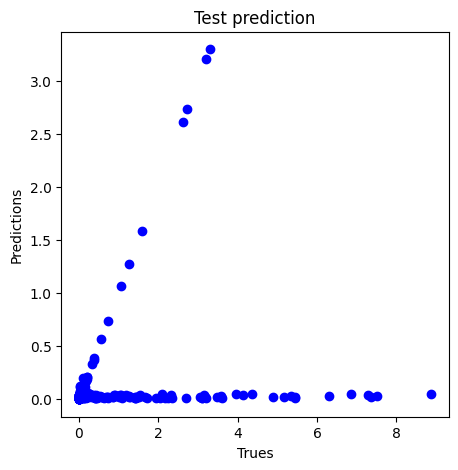

In [139]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_scaled_ts, ae_scaled_preds, c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [140]:
#rescaled_tst_trues = (np.array(test_scaled_ts) - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min
rescaled_tst_preds = (np.array(ae_scaled_preds) - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

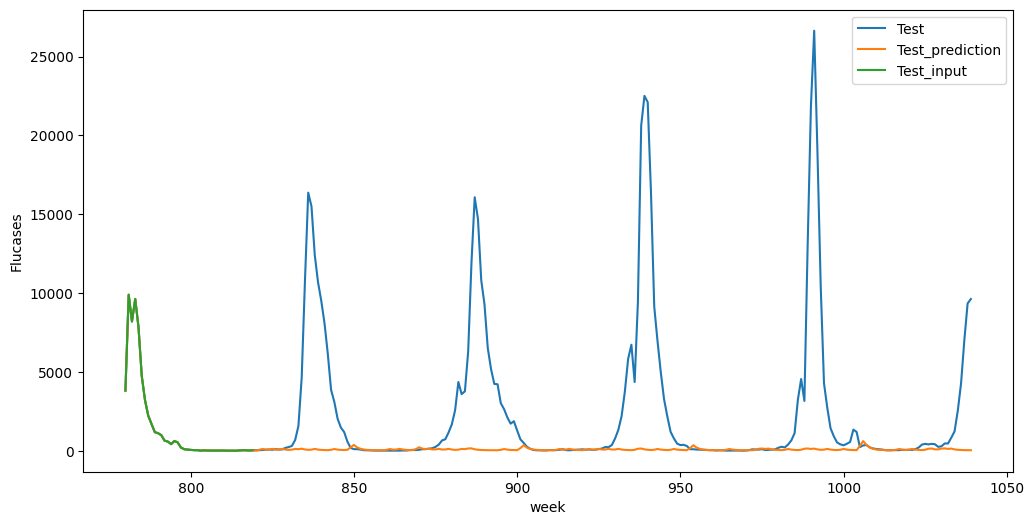

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n],label="Test")
plt.plot(test_steps, rescaled_tst_preds,label="Test_prediction")
plt.plot(test_steps[0:seq_length], rescaled_tst_preds[0:seq_length],label="Test_input")

plt.xlabel("week")
plt.ylabel("Flucases")
plt.legend()